### Описание проекта

**Проект "Промышленность"**
<br>
Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Наша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса.
<br>
**Описание процесса обработки**
<br>Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.
<br>Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.
<br>Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.
<br>Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).
<br><br>
**Описание данных**
<br>Данные хранятся в Sqlite  — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:
<br>steel.data_arc — данные об электродах;
<br>steel.data_bulk — данные об объёме сыпучих материалов;
<br>steel.data_bulk_time — данные о времени подачи сыпучих материалов;
<br>steel.data_gas — данные о продувке сплава газом;
<br>steel.data_temp — данные об измерениях температуры;
<br>steel.data_wire — данные об объёме проволочных материалов;
<br>steel.data_wire_time — данные о времени подачи проволочных материалов.
<br>
<br>**Таблица steel.data_arc**
<br>key — номер партии;
<br>BeginHeat — время начала нагрева;
<br>EndHeat — время окончания нагрева;
<br>ActivePower — значение активной мощности;
<br>ReactivePower — значение реактивной мощности.
<br>
<br>**Таблица steel.data_bulk**
<br>key — номер партии;
<br>Bulk1 … Bulk15 — объём подаваемого материала.
<br>
<br>**Таблица steel.data_bulk_time**
<br>key — номер партии;
<br>Bulk1 … Bulk15 — время подачи материала.
<br>
<br>**Таблица steel.data_gas**
<br>key — номер партии;
<br>gas — объём подаваемого газа.
<br>
<br>**Таблица steel.data_temp**
<br>key — номер партии;
<br>MesaureTime — время замера;
<br>Temperature — значение температуры.
<br>
<br>**Таблица steel.data_wire**
<br>key — номер партии;
<br>Wire1 … Wire9 — объём подаваемых проволочных материалов.
<br>
<br>Таблица steel.data_wire_time
<br>key — номер партии;
<br>Wire1 … Wire9 — время подачи проволочных материалов.
<br>
<br>Во всех файлах столбец key содержит номер партии. В таблицах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

In [1]:
!pip install --upgrade numba

In [2]:
# Установим необходимые библиотеки
!pip install sqlalchemy 
!pip install scikit-learn
!pip -q install phik
!pip install category_encoders
!pip install shap

In [3]:
!pip install --upgrade matplotlib

  Using cached matplotlib-3.9.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.3
    Uninstalling matplotlib-3.6.3:
      Successfully uninstalled matplotlib-3.6.3


In [4]:
!pip install seaborn==0.12.2 matplotlib==3.6.3

  Using cached matplotlib-3.6.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.8 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.9.4
    Uninstalling matplotlib-3.9.4:
      Successfully uninstalled matplotlib-3.9.4


In [5]:
# Импортируем остальные библиотеки
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sqlalchemy import create_engine 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import  StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
import time
from scipy.stats import uniform, randint, binom, norm, spearmanr

from sklearn.model_selection import (StratifiedKFold, cross_val_score,
                                     cross_validate, train_test_split)
import shap
import warnings
from sklearn.exceptions import FitFailedWarning
from scipy.stats import binom, norm, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

warnings.filterwarnings("ignore", category=FitFailedWarning)

# снимим ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

In [6]:
RANDOM_STATE = 110925

### Загрузка данных

Для работы над проектом подключимся к базе данных в Sqlite. Создадим необходимое подключение.

In [7]:
# Воспользуемся предоставленными файлами
!wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db 

path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False) 

--2025-09-17 11:23:54--  https://code.s3.yandex.net/data-scientist/ds-plus-final.db
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3588096 (3.4M) [application/octet-stream]
Saving to: ‘ds-plus-final.db.38’

ds-plus-final.db.38 100%[===================>]   3.42M  --.-KB/s    in 0.07s   

2025-09-17 11:23:55 (46.5 MB/s) - ‘ds-plus-final.db.38’ saved [3588096/3588096]



In [8]:
# Создаем функцию для загрузки данных
def load_and_display_tables(table_list, engine):
    
    dfs = {}
    
    for table in table_list:
        try:
            query = f'''
            SELECT * 
            FROM {table}
            '''
            df = pd.read_sql_query(query, con=engine)
            
            # Создаем переменную с именем таблицы
            globals()[table.replace('.', '_')] = df
            
            
            print(f"\n--- Таблица: {table} ---")
            print("Информация о таблице:")
            print(df.info())
            print("-" * 40)
            
        except Exception as e:
            print(f"Ошибка при загрузке таблицы {table}: {str(e)}")
    
    return 

# Список таблиц для загрузки
tables = [
    'data_arc',
    'data_bulk',
    'data_bulk_time',
    'data_gas',
    'data_temp',
    'data_wire',
    'data_wire_time'
]

In [9]:
# Загрузим данные и ознакомимся с содержанием
load_and_display_tables(tables, engine)


--- Таблица: data_arc ---
Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
----------------------------------------

--- Таблица: data_bulk ---
Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null  

In [10]:
# Составим таблицу для сопоставления количества данных в таблицах

def create_data_summary(table_list):
    # Сначала соберем все партии из всех таблиц
    all_keys = []
    
    # Проходим первый раз для сбора всех партий
    for table_name in table_list:
        df = globals()[table_name]
        if 'key' in df.columns:
            all_keys.append(set(df['key'].unique()))
    
    # Находим пересечение всех множеств партий
    if all_keys:
        common_keys_set = set.intersection(*all_keys)
        common_keys_count = len(common_keys_set)
    else:
        common_keys_count = 'N/A'
    
    summary = []
    
    for table_name in table_list:
        df = globals()[table_name]
        
        num_rows = len(df)
        
        if 'key' in df.columns:
            unique_keys = df['key'].nunique()
            # Находим пересечение с общими партиями
            table_keys = set(df['key'].unique())
            common_in_table = len(table_keys & common_keys_set)
        else:
            unique_keys = 'N/A'
            common_in_table = 'N/A'
        
        summary.append({
            'Таблица': table_name,
            'Количество строк': num_rows,
            'Уникальных партий': unique_keys,
            'Общих уникальных партий': common_in_table
        })
    
    summary_df = pd.DataFrame(summary)
    return summary_df

# Создаем сводную таблицу
summary_table = create_data_summary(tables)

# Выводим результат
display(summary_table)



,Таблица,Количество строк,Уникальных партий,Общих уникальных партий
0,data_arc,14876,3214,3022
1,data_bulk,3129,3129,3022
2,data_bulk_time,3129,3129,3022
3,data_gas,3239,3239,3022
4,data_temp,18092,3216,3022
5,data_wire,3081,3081,3022
6,data_wire_time,3081,3081,3022


Как мы видим, в имеющемся наборе данных есть партии, информация по которым есть не во всех таблицах. Казалось бы, нам не стоит обучать модели на данных по этим партиям и нужно оставить только те партии, данные по которым мы будем иметь во всех признаках обучаемых моделей. Однако, в задании указано о добавлении сыпучих материалов **или** проволоки. **"Или"** - означает, что в партию могут чего-то из перечисленного не добавить, так что отсутствие этих партий в данных по объемам сыпучих материалов или проволоки допустимо.
<br>
Тогда выделим основные таблицы - ['data_arc', 'data_gas', 'data_temp'], где должны быть все партии. Затем удалим строки с партиями, которые неудовлетворяют этому условию во всех таблицах.

In [11]:
# Удалим строки с теми key, которые есть не во всех основных таблицах

# Определяем основные таблицы для поиска ключей
main_tables = ['data_arc', 'data_gas', 'data_temp']

# Все таблицы для очистки
all_tables = ['data_arc', 
             'data_bulk', 
             'data_bulk_time', 
             'data_gas', 
             'data_temp', 
             'data_wire', 
             'data_wire_time']

def find_common_keys(table_list):
    all_keys = []
    
    # Собираем ключи только из основных таблиц
    for table_name in table_list:
        if table_name in main_tables:  # Проверяем, что таблица основная
            df = globals()[table_name]
            if 'key' in df.columns:
                all_keys.append(set(df['key'].unique()))
    
    # Находим пересечение ключей из основных таблиц
    if all_keys:
        return set.intersection(*all_keys)
    return set()

def clean_tables(table_list, common_keys):
    for table_name in table_list:
        if table_name in globals():
            df = globals()[table_name]
            if 'key' in df.columns:
                # Оставляем только строки с общими ключами
                globals()[table_name] = df[df['key'].isin(common_keys)]

# Находим общие ключи из основных таблиц
common_keys = find_common_keys(all_tables)

# Очищаем все таблицы
clean_tables(all_tables, common_keys)

# Пересоздаем сводную таблицу для проверки
summary_table = create_data_summary(all_tables)
display(summary_table)


,Таблица,Количество строк,Уникальных партий,Общих уникальных партий
0,data_arc,14866,3212,3022
1,data_bulk,3126,3126,3022
2,data_bulk_time,3126,3126,3022
3,data_gas,3212,3212,3022
4,data_temp,18078,3212,3022
5,data_wire,3078,3078,3022
6,data_wire_time,3078,3078,3022


Теперь в основных таблицах у нас по 3212 уникальных партий, в таблицах по засыпке 3126 партий, по проволоке - 3078.

Данные подгрузились корректно. Количество таблиц и их содержание в целом соответствует описанию к задаче. Названия столбцов в некоторых таблицах переведены на русский язык. Неверно определен тип временных и некоторых количественных данных. 
<br><br>В имеющемся наборе данных выявлены партии, информация по которым есть не во всех таблицах. Мы удалили строки с  партиями которые есть не во всех основных таблицах.
<br><br>Обращает на себя внимание также наличие большого количества пропусков. Разберемся с выявленными несоответствиями и пропусками на этапе исследовательского анализа.

### Исследовательский анализ данных

In [12]:
tables

['data_arc',
 'data_bulk',
 'data_bulk_time',
 'data_gas',
 'data_temp',
 'data_wire',
 'data_wire_time']

In [13]:
# Создадим функцию преобразования типа временных данных

def to_date(df, *columns):
    
    for column in columns:
        if column in df.columns:
            try:
                df[column] = pd.to_datetime(df[column])
            except Exception as e:
                print(f"Ошибка преобразования столбца {column}: {str(e)}")
        else:
            print(f"Столбец {column} не найден в датафрейме")

In [14]:
# Создадим функцию преобразования типа числовых данных

def to_float(df, *columns):
    
    for column in columns:
        if column in df.columns:
            try:
                # Преобразуем в float64
                df[column] = pd.to_numeric(df[column], errors='coerce').astype('float64')
            except Exception as e:
                print(f"Ошибка преобразования столбца {column}: {str(e)}")
        else:
            print(f"Столбец {column} не найден в датафрейме")

In [15]:
# Создадим функцию вывода гистограмм распределения для числовых данных

def plot_distribution(df, column, bins=30):
    
    if column not in df.columns:
        print(f"Ошибка: столбец {column} не найден в датафрейме")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), 
                            gridspec_kw={'width_ratios': [3, 1]})
    sns.histplot(df[column], bins=bins, kde=True, color='skyblue', edgecolor='black', ax=axes[0])
    axes[0].set_title(f'Гистограмма {column}')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Частота')
    axes[0].grid(True)
    
    sns.boxplot(y=df[column], palette='viridis', ax=axes[1])
    axes[1].set_title(f'Boxplot {column}')
    axes[1].set_ylabel(column)
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

#### data_arc

In [16]:
display(data_arc.head(3))
data_arc.info()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14866 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14866 non-null  int64  
 1   Начало нагрева дугой  14866 non-null  object 
 2   Конец нагрева дугой   14866 non-null  object 
 3   Активная мощность     14866 non-null  float64
 4   Реактивная мощность   14866 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 696.8+ KB


In [17]:
# Переименуем столбцы, поменяем тип данных
data_arc.columns = ['key', 'BeginHeat', 'EndHeat', 'ActivePower', 'ReactivePower']
to_date(data_arc, 'BeginHeat', 'EndHeat')

data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14866 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   key            14866 non-null  int64         
 1   BeginHeat      14866 non-null  datetime64[ns]
 2   EndHeat        14866 non-null  datetime64[ns]
 3   ActivePower    14866 non-null  float64       
 4   ReactivePower  14866 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 696.8 KB


data_arc содержит информацию о подаваемой мощности на нагрев ковша и ее продолжительности. Наличие столбца с реактивной мощностью удивило, она не участвует в нагреве и представляет из себя скорее вредный эффект от индукционной технологии. Но, возможно при производстве как то меняются свойства электрической цепи и тогда эти изменения влияют на эффективность нагрева. В таком случае, эти изменения должны отражатся на соотношении реактивной и активной составляющих мощности. Добавим соответствующий столбец, также добавим столбец с продолжительностью нагрева. Помимо этого, добавим значение Heating, некий параметр отражающий итог воздействия как произведение мощности воздействия (ActivePower) на ее продолжительность (HeatingDuration).

In [18]:
# Создаем новый столбец Power_ratio
data_arc['Power_ratio'] = data_arc['ReactivePower'] / data_arc['ActivePower']

# Создаем новый столбец с продолжительностью нагрева
data_arc['HeatingDuration'] = (data_arc['EndHeat'] - data_arc['BeginHeat']).dt.total_seconds()

# Создаем новый столбец Heating
data_arc['Heating'] = data_arc['ActivePower'] * data_arc['HeatingDuration']

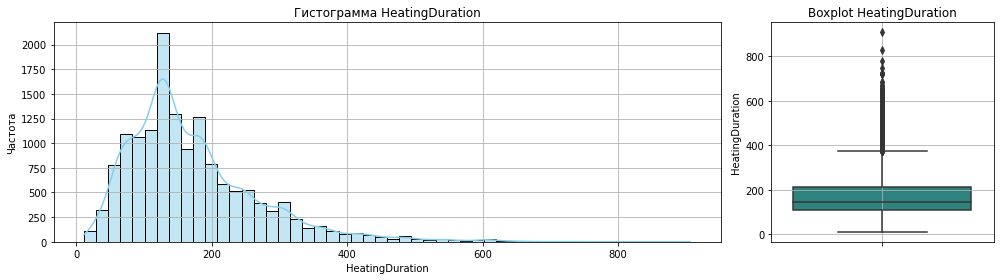

In [19]:
# Выведем диаграммы распределения параметра 'HeatingDuration'
plot_distribution(data_arc, 'HeatingDuration', bins=50)

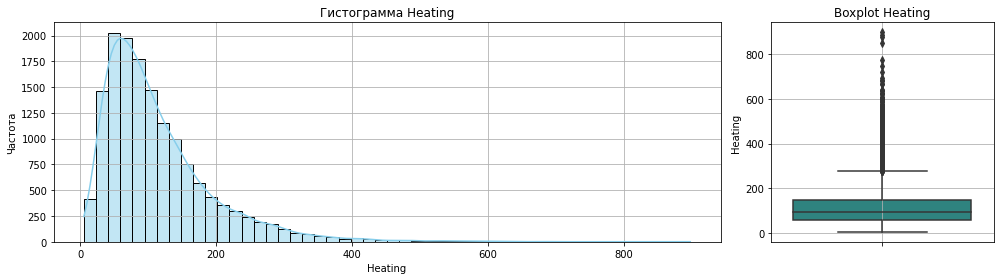

In [20]:
# Выведем диаграммы распределения параметра 'Heating'
plot_distribution(data_arc, 'Heating', bins=50)

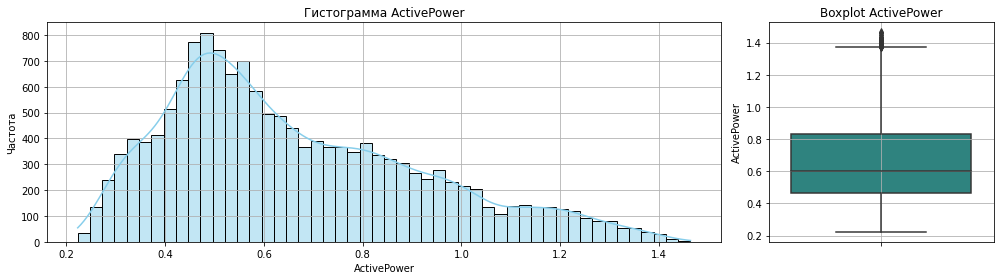

In [21]:
# Выведем диаграммы распределения параметра 'ActivePower'
plot_distribution(data_arc, 'ActivePower', bins=50)

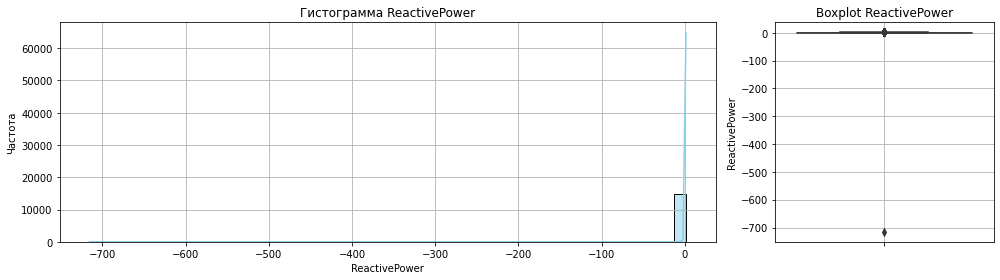

In [22]:
# Выведем диаграммы распределения параметра 'ActivePower'
plot_distribution(data_arc, 'ReactivePower', bins=50)

Выявлен выброс со значением менее -700. Удалим его с выведем заново диаграммы.

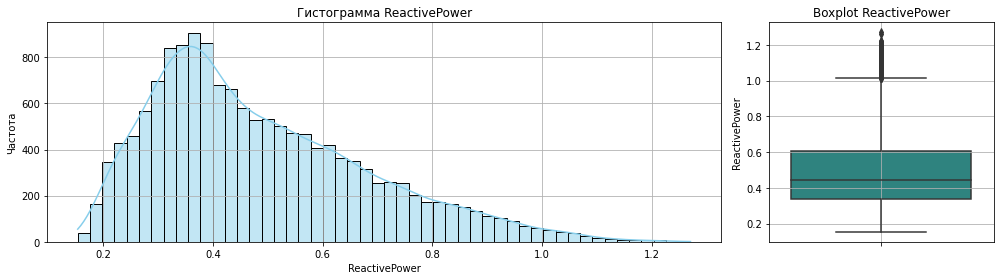

In [23]:
# Удалим партии со значениями ReactivePower менее -100 как аномальные
data_arc = data_arc.loc[data_arc['ReactivePower'] >= -100]

# Выведем диаграммы распределения параметра 'ActivePower'
plot_distribution(data_arc, 'ReactivePower', bins=50)

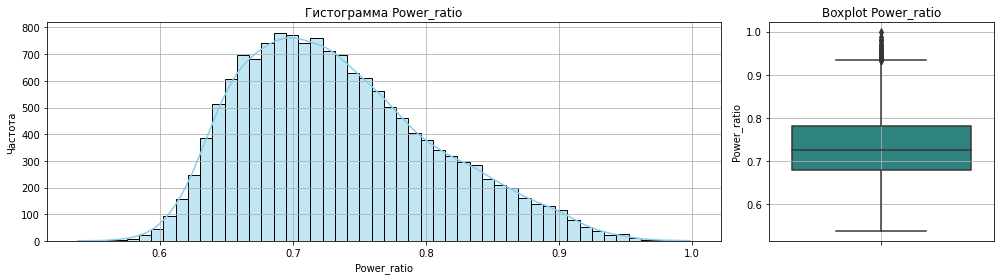

In [24]:
# Выведем диаграммы распределения параметра 'ActivePower'
plot_distribution(data_arc, 'Power_ratio', bins=50)

Диапазон изменения соотношения реактивной и активной мощности свидетельствует о непостоянстве эффективности процесса нагрева ковша, следовательно мы получили важный признак для нашей модели. С остальными распределениями все хорошо, пропусков в data_arc нет.

#### data_bulk

In [25]:
display(data_bulk.tail(3))
data_bulk.info()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3126,3239,NaN,NaN,NaN,NaN,None,114.0,None,None,None,None,None,158.0,None,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,None,26.0,None,None,None,None,None,None,None,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,180.0,52.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3126 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3126 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1013 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   574 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2448 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2804 non-null   object 
 15  Bulk 15  2246 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 415.2+ KB


In [26]:
# Поменяем тип данных на float64 там где это необходимо
column_names = [f'Bulk {i}' for i in range(5, 16)]
to_float(data_bulk, *column_names)
# Пропуски заполним нулевыми значениями
data_bulk = data_bulk.fillna(0)

data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3126 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3126 non-null   int64  
 1   Bulk 1   3126 non-null   float64
 2   Bulk 2   3126 non-null   float64
 3   Bulk 3   3126 non-null   float64
 4   Bulk 4   3126 non-null   float64
 5   Bulk 5   3126 non-null   float64
 6   Bulk 6   3126 non-null   float64
 7   Bulk 7   3126 non-null   float64
 8   Bulk 8   3126 non-null   float64
 9   Bulk 9   3126 non-null   float64
 10  Bulk 10  3126 non-null   float64
 11  Bulk 11  3126 non-null   float64
 12  Bulk 12  3126 non-null   float64
 13  Bulk 13  3126 non-null   float64
 14  Bulk 14  3126 non-null   float64
 15  Bulk 15  3126 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 415.2 KB


In [27]:
# Создадим новый столбец с суммой всех Bulk значений
data_bulk['TotalBulk'] = data_bulk.loc[:, 'Bulk 1':'Bulk 15'].sum(axis=1)

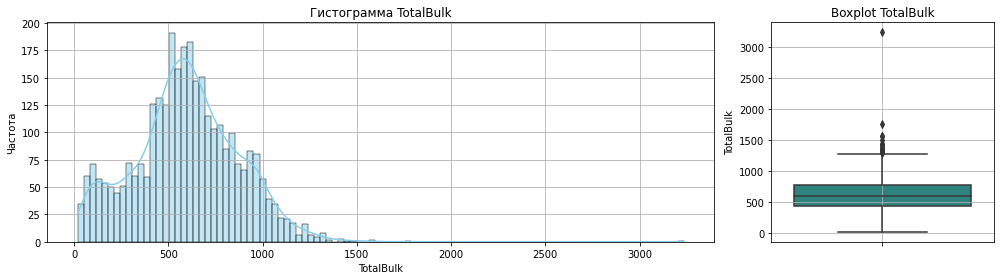

In [28]:
# Выведем диаграммы распределения параметра 'TotalBulk'
plot_distribution(data_bulk, 'TotalBulk', bins=100)

На диаграммах отмечается наличие выбросов в значениях 'TotalBulk'. Посмотрим строки с ними.

In [29]:
data_bulk.sort_values(by='TotalBulk', ascending=False).head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,TotalBulk
303,322,185.0,0.0,101.0,58.0,0.0,0.0,406.0,0.0,0.0,0.0,0.0,1849.0,0.0,636.0,0.0,3235.0
1629,1689,0.0,0.0,0.0,0.0,0.0,247.0,0.0,0.0,0.0,0.0,0.0,733.0,305.0,248.0,224.0,1757.0
308,327,67.0,0.0,0.0,119.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,775.0,0.0,403.0,205.0,1569.0
1933,1999,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,853.0,0.0,366.0,290.0,1563.0
486,513,0.0,0.0,286.0,0.0,0.0,295.0,0.0,0.0,0.0,0.0,0.0,474.0,0.0,219.0,224.0,1498.0


Имеем одну партию с суммарной засыпкой более 3200 единиц объема. Есть небольшие сомнения в достоверности этих значений, но лучше ее оставим пока. Отметим что это партия №322.
В остальном, вопросов к распределениям нет.

#### data_bulk_time

In [30]:
display(data_bulk_time.head(3))
data_bulk_time.info()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3126 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3126 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1013 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   574 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2448 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2804 non-null   object
 15  Bulk 15  2246 non-null   object
dtypes: int64(1), object(15)
memory usage: 415.2+ KB


In [31]:
# Поменяем тип временных данных
column_names = [f'Bulk {i}' for i in range(1, 16)]
to_date(data_bulk_time, *column_names)

display(data_bulk_time.head(3))
data_bulk_time.info()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3126 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3126 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1013 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   574 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2448 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2804 non-null   datetime64[ns]
 15  Bulk 15  2246 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 415.2 KB


Статистика по временным разницам:
               key     time_diff
count  3126.000000   3126.000000
mean   1625.708573    965.322457
std     932.803437    798.268366
min       1.000000      0.000000
25%     818.250000    485.000000
50%    1624.500000    877.000000
75%    2431.750000   1311.750000
max    3241.000000  13683.000000


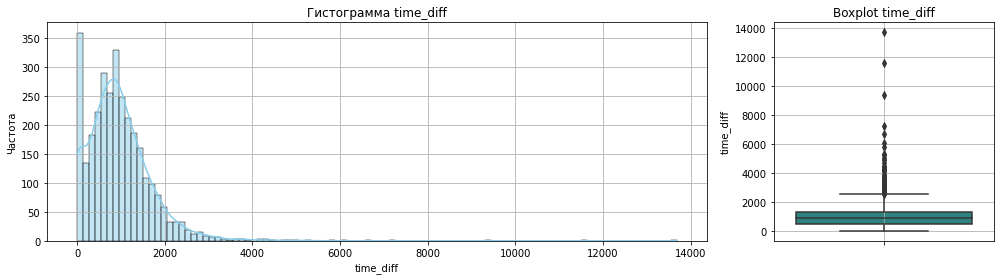


Партии с максимальными временными разницами:


,key,min_time,max_time,time_diff
1892,1958,2019-07-21 10:56:00,2019-07-21 14:44:03,13683.0
1816,1881,2019-07-12 10:42:42,2019-07-12 13:55:14,11552.0
1815,1880,2019-07-12 07:45:54,2019-07-12 10:21:30,9336.0
2856,2965,2019-08-28 03:40:56,2019-08-28 05:41:34,7238.0
2467,2562,2019-08-12 19:51:09,2019-08-12 21:42:20,6671.0


In [32]:
# Посмотрим распределение времени подачи материалов для выявления аномальных значений

time_columns = [f'Bulk {i}' for i in range(1, 16)]  

# Функция для получения минимального и максимального времени
def get_min_max_time(group):
    # Собираем все времена из всех столбцов
    all_times = pd.concat([group[col] for col in time_columns]).dropna()
    
    if not all_times.empty:
        return pd.Series({
            'min_time': all_times.min(),
            'max_time': all_times.max()
        })
    return pd.Series({'min_time': np.nan, 'max_time': np.nan})

# Группируем по key и получаем min/max время
time_stats = data_bulk_time.groupby('key').apply(get_min_max_time).reset_index()

# Рассчитываем разницу между max и min временем
time_stats['time_diff'] = (time_stats['max_time'] - time_stats['min_time']).dt.total_seconds()

# Анализируем результаты
print("Статистика по временным разницам:")
print(time_stats.describe())

# Выведем диаграммы распределения параметра 'time_diff'
plot_distribution(time_stats, 'time_diff', bins=100)

# Выводим партии с наибольшими разницами
print("\nПартии с максимальными временными разницами:")
time_stats.sort_values(by='time_diff', ascending=False).head()

Данные приведены к верному типу. Некорректных значений времени подачи материала не выявлено. Заполнение пропусков не требуется. 

#### data_gas

In [33]:
display(data_gas.head(3))
data_gas.info()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3212 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3212 non-null   int64  
 1   Газ 1   3212 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 75.3 KB


In [34]:
# Переименуем столбцы
data_gas.columns = ['key', 'total_gas']

data_gas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3212 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   key        3212 non-null   int64  
 1   total_gas  3212 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 75.3 KB


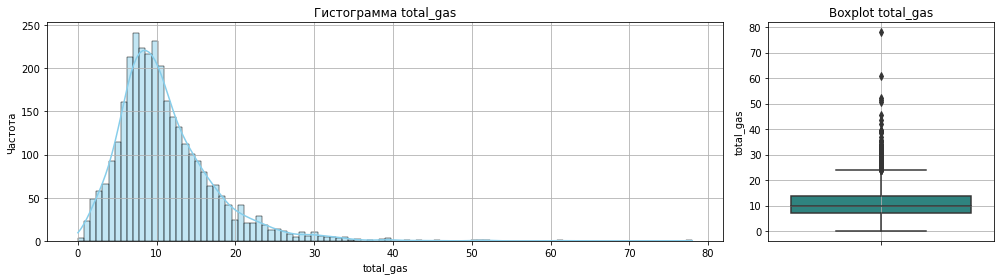

In [35]:
# Выведем диаграммы распределения параметра 'total_gas'
plot_distribution(data_gas, 'total_gas', bins=100)

Пропусков нет, столбцы переименованы.

#### data_temp

In [36]:
display(data_temp.head(3))
data_temp.info()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18078 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18078 non-null  int64 
 1   Время замера  18078 non-null  object
 2   Температура   14651 non-null  object
dtypes: int64(1), object(2)
memory usage: 564.9+ KB


In [37]:
# Переименуем столбцы с учетом дальнейшего выделения целевого признака, поменяем тип данных
data_temp.columns = ['key', 'Time_finish', 'Temp_finish']
to_date(data_temp, 'Time_finish')
to_float(data_temp, 'Temp_finish')

data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18078 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          18078 non-null  int64         
 1   Time_finish  18078 non-null  datetime64[ns]
 2   Temp_finish  14651 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 564.9 KB


В данных много пропусков в столбце 'Temp_finish', заполнить их не получится. Помимо этого, нам стоит избавиться также от тех партий в которых есть эти пропуски, т.к. пропуски могут быть и в первых замерах и в последних, а это наши будующие признаки. Кроме этого, в задании указано что значения температуры менее 1500 градусов - аномальные, удалим их тоже.

In [38]:
# Удалим партии в которых есть пропуски
# Находим партии с пропусками
keys_with_na = data_temp[data_temp['Temp_finish'].isna()]['key'].unique()
# Фильтруем датафрейм
data_temp = data_temp[~data_temp['key'].isin(keys_with_na)]

In [39]:
# Оценим результат
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13912 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          13912 non-null  int64         
 1   Time_finish  13912 non-null  datetime64[ns]
 2   Temp_finish  13912 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 434.8 KB


In [40]:
# Удалим партии со значениями температуры менее 1500 как аномальные
data_temp = data_temp.loc[data_temp['Temp_finish'] >= 1500]
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13908 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          13908 non-null  int64         
 1   Time_finish  13908 non-null  datetime64[ns]
 2   Temp_finish  13908 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 434.6 KB


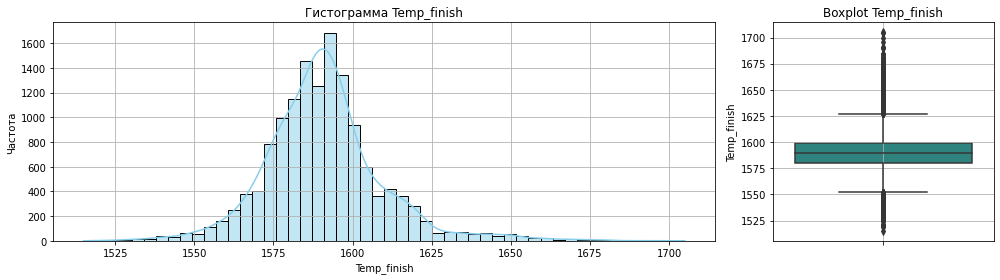

In [41]:
# Выведем диаграммы распределения температуры
plot_distribution(data_temp, 'Temp_finish', bins=50)

Распределения в норме. Пропуски в данных удалены.

#### data_wire

In [42]:
display(data_wire.tail(3))
data_wire.info()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3078,3239,143.357761,None,None,None,None,None,None,None,None
3079,3240,34.070400,None,None,None,None,None,None,None,None
3080,3241,63.117595,None,None,None,None,None,None,None,None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3078 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3078 non-null   int64  
 1   Wire 1  3052 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 264.5+ KB


In [43]:
# Поменяем тип данных на float64 там где это необходимо
column_names = [f'Wire {i}' for i in range(2, 10)]
to_float(data_wire, *column_names)
# Пропуски заполним нулевыми значениями
data_wire = data_wire.fillna(0)

data_wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3078 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3078 non-null   int64  
 1   Wire 1  3078 non-null   float64
 2   Wire 2  3078 non-null   float64
 3   Wire 3  3078 non-null   float64
 4   Wire 4  3078 non-null   float64
 5   Wire 5  3078 non-null   float64
 6   Wire 6  3078 non-null   float64
 7   Wire 7  3078 non-null   float64
 8   Wire 8  3078 non-null   float64
 9   Wire 9  3078 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 264.5 KB


In [44]:
# Создадим новый столбец с суммой всех Wire значений
data_wire['TotalWire'] = data_wire.loc[:, 'Wire 1':'Wire 9'].sum(axis=1)

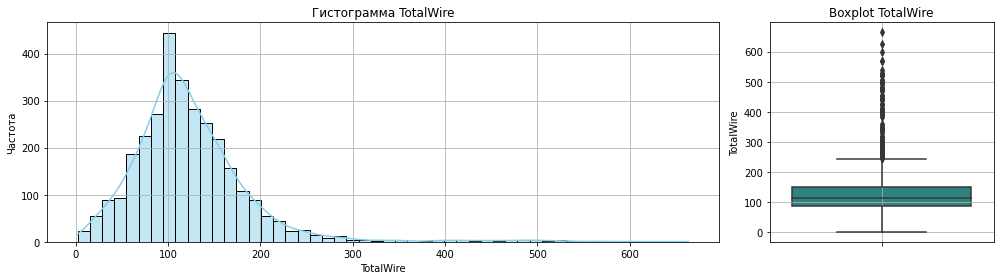

In [45]:
# Выведем диаграммы распределения параметра 'TotalWire'
plot_distribution(data_wire, 'TotalWire', bins=50)

Замечательно. К распределениям вопросов нет.

#### data_wire_time

In [46]:
display(data_wire_time.tail(3))
data_wire_time.info()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3078,3239,2019-09-06 14:36:11,None,None,None,None,None,None,None,None
3079,3240,2019-09-06 15:33:55,None,None,None,None,None,None,None,None
3080,3241,2019-09-06 17:10:06,None,None,None,None,None,None,None,None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3078 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3078 non-null   int64 
 1   Wire 1  3052 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 264.5+ KB


In [47]:
# Поменяем тип временных данных
column_names = [f'Wire {i}' for i in range(1, 10)]
to_date(data_wire_time, *column_names)

display(data_wire_time.head(3))
data_wire_time.info()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3078 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3078 non-null   int64         
 1   Wire 1  3052 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 264.5 KB


Статистика по временным разницам:
               key    time_diff
count  3078.000000  3078.000000
mean   1624.771280   214.728395
std     932.455021   396.268367
min       1.000000     0.000000
25%     825.250000     0.000000
50%    1620.500000     0.000000
75%    2434.750000   401.750000
max    3241.000000  5937.000000


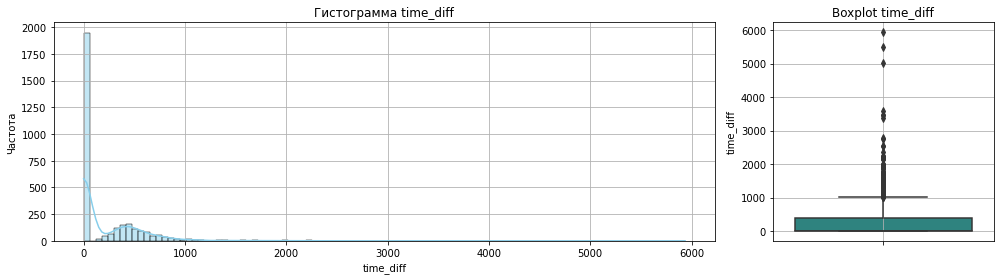


Партии с максимальными временными разницами:


,key,min_time,max_time,time_diff
2009,2110,2019-07-27 19:11:22,2019-07-27 20:50:19,5937.0
2007,2108,2019-07-27 13:43:32,2019-07-27 15:15:04,5492.0
2436,2566,2019-08-13 02:52:06,2019-08-13 04:15:39,5013.0
2437,2567,2019-08-13 06:10:36,2019-08-13 07:10:14,3578.0
97,113,2019-05-07 14:46:05,2019-05-07 15:44:02,3477.0


In [48]:
# Посмотрим распределение времени подачи материалов для выявления аномальных значений

time_columns = [f'Wire {i}' for i in range(1, 10)]  

# Функция для получения минимального и максимального времени
def get_min_max_time(group):
    # Собираем все времена из всех столбцов
    all_times = pd.concat([group[col] for col in time_columns]).dropna()
    
    if not all_times.empty:
        return pd.Series({
            'min_time': all_times.min(),
            'max_time': all_times.max()
        })
    return pd.Series({'min_time': np.nan, 'max_time': np.nan})

# Группируем по key и получаем min/max время
time_stats = data_wire_time.groupby('key').apply(get_min_max_time).reset_index()

# Рассчитываем разницу между max и min временем
time_stats['time_diff'] = (time_stats['max_time'] - time_stats['min_time']).dt.total_seconds()

# Анализируем результаты
print("Статистика по временным разницам:")
print(time_stats.describe())

# Выведем диаграммы распределения параметра 'time_diff'
plot_distribution(time_stats, 'time_diff', bins=100)

# Выводим партии с наибольшими разницами
print("\nПартии с максимальными временными разницами:")
time_stats.sort_values(by='time_diff', ascending=False).head()

Данные приведены к верному типу. Некорректных значений времени подачи материала не выявлено. Заполнение пропусков не требуется.

### Объединение данных

В задании указано "... целевой признак — **последняя температура партии**. Начальную температуру партии можно использовать как входной признак. Любые другие промежуточные значения температуры приведут к утечке целевого признака, их нельзя использовать как входные." 
<br>
С последним утверждением мы попробуем разобраться в отдельной (дополнительной) части проекта, сейчас же мы будем строго следовать заданию к проекту.

#### data_temp

In [49]:
data_temp.head()

,key,Time_finish,Temp_finish
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [50]:
# Создадим функцию для агрегации данных
def aggregate_group(group):
    # Находим минимальное время и соответствующую температуру
    min_time = group['Time_finish'].min()
    temp_start = group.loc[group['Time_finish'] == min_time, 'Temp_finish'].iloc[0]
    
    # Находим максимальное время и соответствующую температуру
    max_time = group['Time_finish'].max()
    temp_finish = group.loc[group['Time_finish'] == max_time, 'Temp_finish'].iloc[0]
    
    return pd.Series({
        'Time_start': min_time,
        'Temp_start': temp_start,
        'Time_finish': max_time,
        'Temp_finish': temp_finish
    })

# Группируем данные
main_df = data_temp.groupby('key').apply(aggregate_group).reset_index()

# Добавляем длительность как разницу между временем окончания и начала
main_df['Duration'] = (main_df['Time_finish'] - main_df['Time_start']).dt.total_seconds()

display(main_df.head())
main_df.info()

,key,Time_start,Temp_start,Time_finish,Temp_finish,Duration
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,1714.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,1265.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,1753.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,1220.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,1536.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2473 entries, 0 to 2472
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          2473 non-null   int64         
 1   Time_start   2473 non-null   datetime64[ns]
 2   Temp_start   2473 non-null   float64       
 3   Time_finish  2473 non-null   datetime64[ns]
 4   Temp_finish  2473 non-null   float64       
 5   Duration     2473 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 116.0 KB


In [51]:
# Удалим строки с нулевой продолжительностью
main_df = main_df[main_df['Duration'] != 0]
main_df.sort_values(by='Duration')

,key,Time_start,Temp_start,Time_finish,Temp_finish,Duration
1600,1619,2019-07-03 02:39:29,1623.0,2019-07-03 02:43:59,1590.0,270.0
1754,1773,2019-07-08 08:58:18,1609.0,2019-07-08 09:03:57,1592.0,339.0
1320,1338,2019-06-22 17:44:53,1599.0,2019-06-22 17:51:03,1598.0,370.0
148,151,2019-05-09 11:07:21,1557.0,2019-05-09 11:14:46,1565.0,445.0
2460,2486,2019-08-10 01:05:47,1589.0,2019-08-10 01:13:25,1592.0,458.0
...,...,...,...,...,...,...
625,638,2019-05-27 17:46:42,1588.0,2019-05-27 21:30:10,1619.0,13408.0
628,641,2019-05-28 03:43:37,1617.0,2019-05-28 08:34:44,1580.0,17467.0
1939,1958,2019-07-21 09:21:56,1579.0,2019-07-21 14:45:25,1570.0,19409.0
2087,2108,2019-07-27 10:41:03,1639.0,2019-07-27 16:36:34,1541.0,21331.0


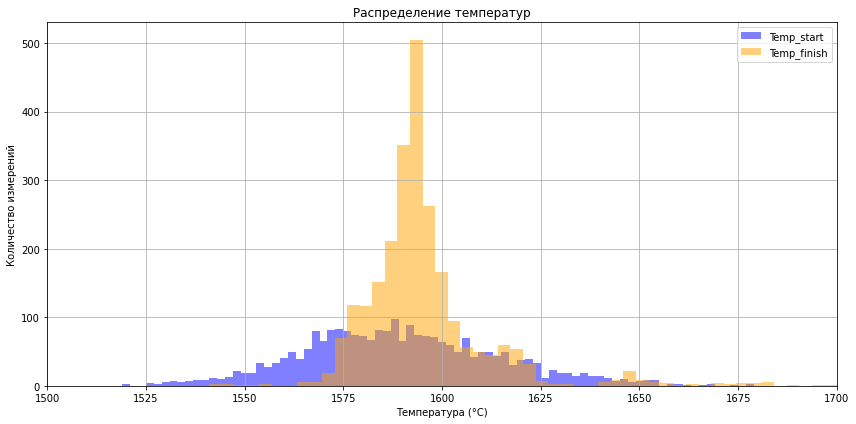

In [52]:
# Выведем распределения начальных и конечных температур на один график
plt.figure(figsize=(12, 6))
plt.hist(main_df['Temp_start'], bins=80, alpha=0.5, color='blue', label='Temp_start')
plt.hist(main_df['Temp_finish'], bins=50, alpha=0.5, color='orange', label='Temp_finish')
plt.title('Распределение температур')
plt.xlabel('Температура (°C)')
plt.ylabel('Количество измерений')
plt.xlim(1500, 1700)  # Устанавливаем границы по оси X
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### data_arc

In [53]:
data_arc.head()

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,Power_ratio,HeatingDuration,Heating
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.692338,228.0,69.569640
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.623566,185.0,141.646730
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.741772,172.0,99.813836
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.732848,365.0,189.251040
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0.742321,148.0,128.335684


Данные по 'ActivePower' и 'ReactivePower' есть в 'Power_ratio' и 'Heating', поэтому в качестве признаков для моделей возьмем только 'Power_ratio', 'HeatingDuration' и 'Heating'. 

In [54]:
# Группируем данные
data_arc_group = data_arc.groupby('key').agg(
    Power_ratio=('Power_ratio', 'mean'),
    HeatingDuration=('HeatingDuration', 'sum'),
    Heating=('Heating', 'sum')
).reset_index()
data_arc_group.head()

,key,Power_ratio,HeatingDuration,Heating
0,1,0.706569,1098.0,628.616930
1,2,0.684080,811.0,395.281800
2,3,0.725034,655.0,581.774624
3,4,0.765897,741.0,543.710274
4,5,0.758599,869.0,412.180480


In [55]:
# Присоединяем к main_df 
main_df = pd.merge(
    main_df,
    data_arc_group,
    on='key',
    how='left'  
)
main_df.head()

,key,Time_start,Temp_start,Time_finish,Temp_finish,Duration,Power_ratio,HeatingDuration,Heating
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,1714.0,0.706569,1098.0,628.616930
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,1265.0,0.684080,811.0,395.281800
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,1753.0,0.725034,655.0,581.774624
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,1220.0,0.765897,741.0,543.710274
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,1536.0,0.758599,869.0,412.180480


#### bulk, wire, gas

In [56]:
# Присоединяем к main_df data_bulk
main_df = pd.merge(
    main_df,
    data_bulk,
    on='key',
    how='left'  
)
main_df.head()

,key,Time_start,Temp_start,Time_finish,Temp_finish,Duration,Power_ratio,HeatingDuration,Heating,Bulk 1,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,TotalBulk
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,1714.0,0.706569,1098.0,628.616930,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,1265.0,0.684080,811.0,395.281800,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,1753.0,0.725034,655.0,581.774624,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,1220.0,0.765897,741.0,543.710274,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,1536.0,0.758599,869.0,412.180480,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0


In [57]:
# Присоединяем к main_df data_wire
main_df = pd.merge(
    main_df,
    data_wire,
    on='key',
    how='left'  
)
main_df.head()

,key,Time_start,Temp_start,Time_finish,Temp_finish,Duration,Power_ratio,HeatingDuration,Heating,Bulk 1,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,TotalWire
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,1714.0,0.706569,1098.0,628.616930,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,1265.0,0.684080,811.0,395.281800,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,1753.0,0.725034,655.0,581.774624,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,1220.0,0.765897,741.0,543.710274,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,1536.0,0.758599,869.0,412.180480,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


In [58]:
# Присоединяем к main_df data_gas
main_df = pd.merge(
    main_df,
    data_gas,
    on='key',
    how='left'  
)
main_df.head()

,key,Time_start,Temp_start,Time_finish,Temp_finish,Duration,Power_ratio,HeatingDuration,Heating,Bulk 1,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,TotalWire,total_gas
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,1714.0,0.706569,1098.0,628.616930,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,29.749986
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,1265.0,0.684080,811.0,395.281800,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,12.555561
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,1753.0,0.725034,655.0,581.774624,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,28.554793
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,1220.0,0.765897,741.0,543.710274,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,18.841219
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,1536.0,0.758599,869.0,412.180480,0.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,5.413692


In [59]:
# Очистим main_df от столбцов со временем и key
main_df = main_df.drop(columns=['key', 'Time_start', 'Time_finish'])
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 0 to 2472
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Temp_start       2473 non-null   float64
 1   Temp_finish      2473 non-null   float64
 2   Duration         2473 non-null   float64
 3   Power_ratio      2473 non-null   float64
 4   HeatingDuration  2473 non-null   float64
 5   Heating          2473 non-null   float64
 6   Bulk 1           2405 non-null   float64
 7   Bulk 2           2405 non-null   float64
 8   Bulk 3           2405 non-null   float64
 9   Bulk 4           2405 non-null   float64
 10  Bulk 5           2405 non-null   float64
 11  Bulk 6           2405 non-null   float64
 12  Bulk 7           2405 non-null   float64
 13  Bulk 8           2405 non-null   float64
 14  Bulk 9           2405 non-null   float64
 15  Bulk 10          2405 non-null   float64
 16  Bulk 11          2405 non-null   float64
 17  Bulk 12       

In [60]:
# Заполним оставшиеся пропуски в Bulk и Wire нулевыми значениями
main_df = main_df.fillna(0)
main_df.sort_values(by='Duration')

,Temp_start,Temp_finish,Duration,Power_ratio,HeatingDuration,Heating,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,TotalWire,total_gas
1600,1623.0,1590.0,270.0,0.798554,246.0,117.210974,0.0,0.0,45.0,0.0,...,45.179680,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,200.321678,4.542025
1754,1609.0,1592.0,339.0,0.695412,119.0,41.494029,0.0,0.0,19.0,0.0,...,40.082642,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,129.236634,5.208462
1320,1599.0,1598.0,370.0,0.764003,178.0,149.120144,0.0,0.0,43.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,46.098000,4.579572
148,1557.0,1565.0,445.0,0.679666,296.0,163.202750,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,6.158880,2.026554
2460,1589.0,1592.0,458.0,0.750604,328.0,130.804837,0.0,0.0,0.0,49.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,35.075039,5.976477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,1588.0,1619.0,13408.0,0.688611,2067.0,1370.876001,0.0,0.0,99.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,169.322388,19.798236
628,1617.0,1580.0,17467.0,0.711129,1413.0,789.999703,0.0,0.0,0.0,60.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,221.176796,20.984894
1939,1579.0,1570.0,19409.0,0.784597,1834.0,1138.560690,0.0,0.0,31.0,0.0,...,150.106322,0.960960,0.000000,0.0,0.000000,0.000000,0.0,0.0,274.375926,32.449632
2087,1639.0,1541.0,21331.0,0.708073,2739.0,1761.888070,63.0,242.0,0.0,98.0,...,0.000000,93.213127,92.570401,0.0,63.045845,1.053936,0.0,0.0,260.934349,45.638999


In [61]:
# Выведем количество партий с нулями в столбце TotalWire и в столбце TotalBulk одновременно
len(main_df.loc[(main_df['TotalWire'] == 0) & (main_df['TotalBulk'] == 0)])

27

In [62]:
# Удалим эти партии
main_df = main_df.loc[~((main_df['TotalWire'] == 0) & (main_df['TotalBulk'] == 0))]
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2446 entries, 0 to 2472
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Temp_start       2446 non-null   float64
 1   Temp_finish      2446 non-null   float64
 2   Duration         2446 non-null   float64
 3   Power_ratio      2446 non-null   float64
 4   HeatingDuration  2446 non-null   float64
 5   Heating          2446 non-null   float64
 6   Bulk 1           2446 non-null   float64
 7   Bulk 2           2446 non-null   float64
 8   Bulk 3           2446 non-null   float64
 9   Bulk 4           2446 non-null   float64
 10  Bulk 5           2446 non-null   float64
 11  Bulk 6           2446 non-null   float64
 12  Bulk 7           2446 non-null   float64
 13  Bulk 8           2446 non-null   float64
 14  Bulk 9           2446 non-null   float64
 15  Bulk 10          2446 non-null   float64
 16  Bulk 11          2446 non-null   float64
 17  Bulk 12       

In [63]:
# Посмотрим количество полезной информации в столбцах
zero_counts_per_column = (main_df == 0).sum()
info_percentage = (1-(zero_counts_per_column / len(main_df))) * 100

info_percentage.sort_values()

Wire 5               0.000000
Bulk 8               0.040883
Wire 7               0.163532
Wire 4               0.490597
Wire 8               0.531480
Bulk 9               0.531480
Bulk 2               0.531480
Bulk 13              0.572363
Bulk 7               0.572363
Wire 9               1.144726
Wire 3               1.594440
Wire 6               1.839738
Bulk 5               2.166803
Bulk 11              5.314800
Bulk 10              5.846280
Bulk 1               8.135732
Bulk 6              18.070319
Bulk 4              33.237939
Wire 2              34.055601
Bulk 3              39.452167
Bulk 15             69.950940
Bulk 12             76.860180
Bulk 14             87.285364
Wire 1              95.911693
TotalWire           96.892886
TotalBulk           98.323794
Temp_start         100.000000
HeatingDuration    100.000000
Power_ratio        100.000000
Duration           100.000000
Temp_finish        100.000000
Heating            100.000000
total_gas          100.000000
dtype: flo

Wire 5 - пустой столбец, также есть несколько столбцов с минимальным объемом информации. Объединим данные по ним в отдельные столбцы Wire_other и Bulk_other.

In [64]:
# Объединим данные по столбцам в которых info_percentage менее 1 в отдельные столбцы Wire_other и Bulk_other

sorted_info = info_percentage.sort_values()
low_info_columns = sorted_info[sorted_info < 1].index
main_df['Wire_other'] = 0
main_df['Bulk_other'] = 0
wire_columns = [col for col in low_info_columns if 'Wire' in col]
bulk_columns = [col for col in low_info_columns if 'Bulk' in col]

if wire_columns:
    main_df['Wire_other'] = main_df[wire_columns].sum(axis=1)
    main_df.drop(columns=wire_columns, inplace=True)

if bulk_columns:
    main_df['Bulk_other'] = main_df[bulk_columns].sum(axis=1)
    main_df.drop(columns=bulk_columns, inplace=True)

# Проверим результат
main_df.columns

Index(['Temp_start', 'Temp_finish', 'Duration', 'Power_ratio',
       'HeatingDuration', 'Heating', 'Bulk 1', 'Bulk 3', 'Bulk 4', 'Bulk 5',
       'Bulk 6', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 14', 'Bulk 15',
       'TotalBulk', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 6', 'Wire 9',
       'TotalWire', 'total_gas', 'Wire_other', 'Bulk_other'],
      dtype='object')

### Корреляционный анализ данных

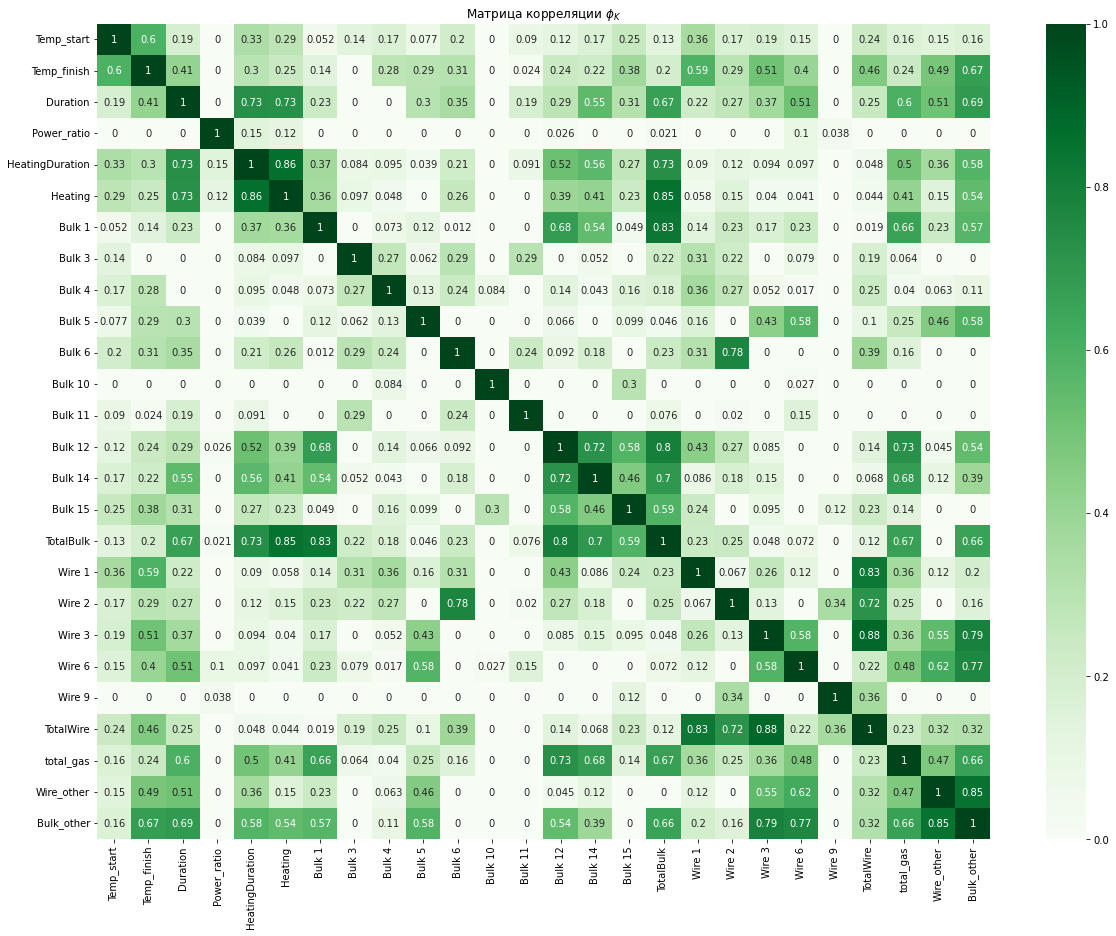

In [65]:
# Обозначим количественные признаки для матрицы
interval_cols = main_df.columns.tolist()

# Выведем матрицу корреляции
target_matrix = main_df.phik_matrix(interval_cols = interval_cols)
plt.figure(figsize=(20, 15))
sns.heatmap(target_matrix, annot=True, cmap='Greens')
plt.title('Матрица корреляции $\phi_K$')
plt.show()

In [66]:
# Выделим и отсортируем коэффициенты корреляции с нашим целевым признаком
target_matrix['Temp_finish'].sort_values(ascending=False)

Temp_finish        1.000000
Bulk_other         0.674392
Temp_start         0.596937
Wire 1             0.590944
Wire 3             0.510070
Wire_other         0.485558
TotalWire          0.461585
Duration           0.407829
Wire 6             0.395121
Bulk 15            0.378748
Bulk 6             0.307339
HeatingDuration    0.297544
Bulk 5             0.294740
Wire 2             0.290465
Bulk 4             0.282746
Heating            0.247915
Bulk 12            0.243215
total_gas          0.241441
Bulk 14            0.218908
TotalBulk          0.202149
Bulk 1             0.141071
Bulk 11            0.024322
Wire 9             0.000000
Bulk 10            0.000000
Bulk 3             0.000000
Power_ratio        0.000000
Name: Temp_finish, dtype: float64

Максимальный коэффициент корреляции составил 0.88 между Wire 3 и Wire_total, но даже в этом случае речь не идет о выраженной мультиколлинеарности. Оставляем данные признаки в работе.

### Обучение моделей

In [67]:
# Подготовим выборки для обучения моделей

# Разделим датасет на входные признаки и целевой
X = main_df.drop('Temp_finish', axis=1)
y = main_df['Temp_finish']

# Разделим данные на тренировочные и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE)

# Стандартизируем числовые признаки
scaler = StandardScaler()

# Применим масштабирование только к тренировочной выборке
X_train = scaler.fit_transform(X_train)

# Применим то же масштабирование к тестовой выборке
X_test = scaler.transform(X_test)

In [68]:
# Функция для создания модели
def create_model(optimizer='adam', init='he_uniform', dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_initializer=init))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu', kernel_initializer=init))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    adam = Adam(learning_rate=0.01)
    model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mae'])
    return model

In [69]:
# Создадим функцию для вывода результатов модели
def evaluate_model(model, params):
    grid = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    
        
    mean_mae = -grid.best_score_
    
    return {
        'best_params': grid.best_params_,
        'mae': mean_mae, 
        'best_estimator': grid.best_estimator_
    }

In [70]:
# 1. Линейная регрессия
print("Линейная регрессия")
linear_pipeline = make_pipeline(
    LinearRegression()
)

linear_params = {}

linear_results = evaluate_model(linear_pipeline, linear_params)
print(f"Лучшие параметры: {linear_results['best_params']}")
print(f"MAE: {linear_results['mae']:.4f}\n")  

# 2. Decision Tree
print("Decision Tree")
tree_params = {
    'max_depth': range(2, 30, 5),
    'min_samples_split': range(2, 30, 5),
    'min_samples_leaf': range(2, 30, 5)
}

tree_results = evaluate_model(DecisionTreeRegressor(), tree_params)
print(f"Лучшие параметры: {tree_results['best_params']}")
print(f"MAE: {tree_results['mae']:.4f}\n") 

# 3. CatBoost
print("CatBoost")
catboost_params = {
    'iterations': [300, 500],
    'learning_rate': [0.03, 0.05, 0.07],
    'depth': [6, 8],
    'l2_leaf_reg': [3, 5]
}

catboost_results = evaluate_model(CatBoostRegressor(verbose=0), catboost_params)
print(f"Лучшие параметры: {catboost_results['best_params']}")
print(f"MAE: {catboost_results['mae']:.4f}\n")  

# 4. Нейронная сеть
print("Нейронная сеть")

# Создаем обертку для Keras модели
neural_net = KerasRegressor(
    build_fn=create_model,
    epochs=1000,
    batch_size=32,
    verbose=0
)

# Параметры для настройки
neural_params = {
    'optimizer': ['adam'],
    'init': ['he_uniform'],
    'epochs': [1000],
    'batch_size': [32],
    'dropout_rate': [0.2]
}
print("\nЗапуск поиска оптимальных параметров для нейронной сети...")

neural_results = evaluate_model(neural_net, neural_params)
print(f"Лучшие параметры: {neural_results['best_params']}")
print(f"MAE: {neural_results['mae']:.4f}\n") 

Линейная регрессия
Лучшие параметры: {}
MAE: 7.1588

Decision Tree
Лучшие параметры: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 27}
MAE: 7.3554

CatBoost
Лучшие параметры: {'depth': 6, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.03}
MAE: 6.1136

Нейронная сеть

Запуск поиска оптимальных параметров для нейронной сети...


/tmp/ipykernel_333/3335872987.py:42: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  neural_net = KerasRegressor(
2025-09-17 11:29:22.876847: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Лучшие параметры: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 1000, 'init': 'he_uniform', 'optimizer': 'adam'}
MAE: 14.8375



### Проверка лучшей модели на тестовых данных

In [71]:
# Загружаем лучшую модель
best_estimator = catboost_results['best_estimator']

# Делаем предсказания на тестовых данных
y_test_pred = best_estimator.predict(X_test)

# Оцениваем результаты
test_mae = mean_absolute_error(y_test, y_test_pred)
print(f"\nТестовая MAE на лучшей модели: {test_mae:.4f}")


Тестовая MAE на лучшей модели: 5.9063


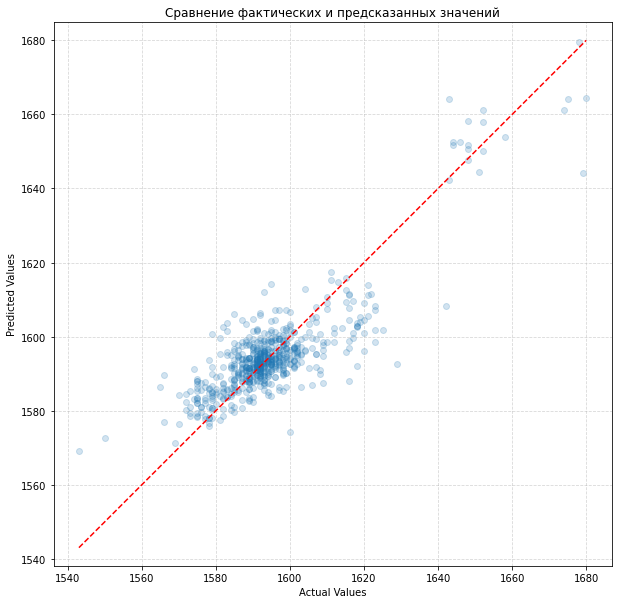

In [72]:
# Построим график сравнения фактических и предсказанных значений
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_test_pred, alpha=0.2)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.axis('equal')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Сравнение фактических и предсказанных значений')
plt.show()


Анализ важности признаков для модели CatBoost:


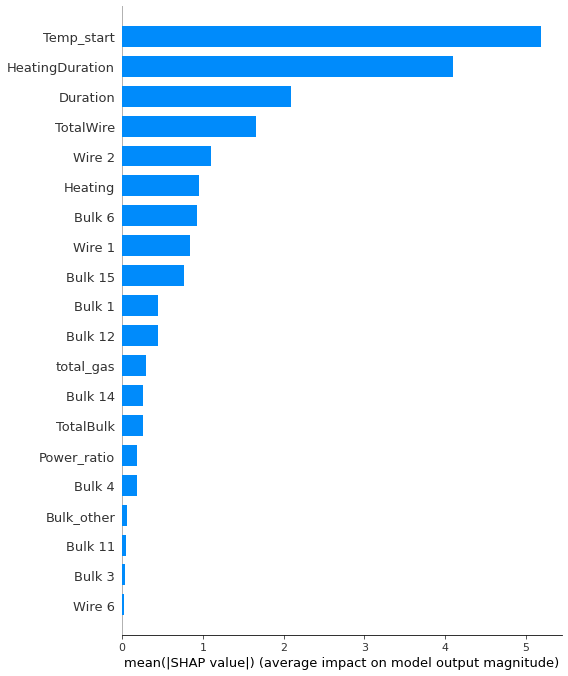


Глобальный анализ влияния признаков:


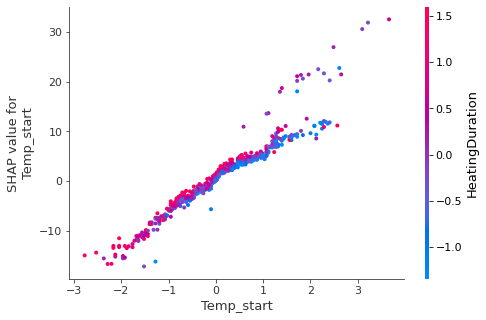


Основные метрики SHAP:
Ожидаемое значение: 1594.7886
Среднее абсолютное значение SHAP: 0.7956

Анализ парных зависимостей:


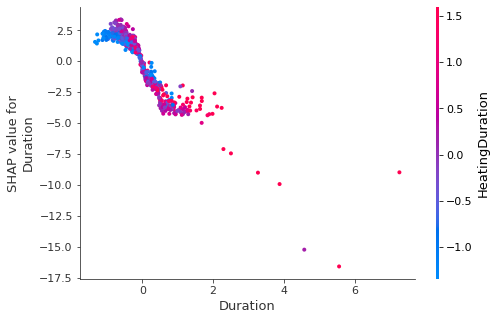

In [73]:

# Создаем explainer для CatBoost
explainer = shap.TreeExplainer(best_estimator)
shap_values = explainer.shap_values(X_test)
X_test_df = pd.DataFrame(X_test, columns=X.columns)
expected_value = explainer.expected_value

# Анализ результатов
print("\nАнализ важности признаков для модели CatBoost:")
shap.summary_plot(shap_values, X_test_df, plot_type='bar')


# Глобальный анализ влияния признаков
print("\nГлобальный анализ влияния признаков:")
shap.dependence_plot(
    ind=X.columns[0],  
    shap_values=shap_values,
    features=X_test_df
)
# Дополнительные метрики
print("\nОсновные метрики SHAP:")
print(f"Ожидаемое значение: {expected_value:.4f}")
print(f"Среднее абсолютное значение SHAP: {np.mean(np.abs(shap_values)):.4f}")

# Анализ парных зависимостей с правильными названиями
print("\nАнализ парных зависимостей:")
shap.dependence_plot(
    ind=X.columns[1],  
    shap_values=shap_values,
    features=X_test_df,
    color=X.columns[2]  
)


На основе представленных графиков и метрик SHAP можно сделать следующие выводы:
<br><br>
Наиболее важные признаки:
<br>
**Temp_start**: Этот признак оказывает наибольшее влияние на модель, что не удивительно. Стартовая температура определяет общий объем необходимой энергии для нагрева.
<br>
**HeatingDuration**: Второй по значимости признак, который также сильно влияет на результаты модели. Продолжительность нагрева характеризует количества тепла затраченного на нагрев ковша при ограниченном диапазоне подводимой мощности.
<br>
**Duration**: Занимает третье место по важности.
<br><br>
Влияние признаков на целевую переменную:
<br>
**Temp_start**: Этот признак оказывает значительное влияние на целевую переменную. Высокие значения Temp_start (около 2) приводят к положительным значениям SHAP, что указывает на их положительное влияние. Низкие значения (около -2) имеют отрицательное влияние.
<br>
**HeatingDuration**: Этот признак также важен. Положительные значения SHAP наблюдаются при высоких значениях HeatingDuration, что говорит о их положительном влиянии. Низкие значения имеют отрицательное влияние.
<br>
**Duration**: Этот признак имеет меньшее влияние по сравнению с Temp_start и HeatingDuration. Однако, в коротких по продолжительности партиях этот параметр оказывает большее влияние на целевую переменную, а в длинных - минимальное.
<br><br>
Парные зависимости:
<br>
График парных зависимостей показывает, что между признаками существуют сложные взаимосвязи. Например, при увеличении HeatingDuration значения SHAP для Duration также увеличиваются, что может указывать на их совместное влияние на целевую переменную.
<br><br>
Метрики SHAP:
<br>
Ожидаемое значение: 1595.2627. Это базовое значение модели, от которого рассчитываются SHAP-значения.
<br>
Среднее абсолютное значение SHAP: 0.8835. Это указывает на среднюю важность признаков в модели.

### Вывод:

Для работы над проектом в нашем распоряжении было семь таблиц с данными отражающими процесс производства сплавов. Все полученные данные были подвергнуты преобработке с исключением непригодной информации и последующему исследовательскому анализу. 
<br>
Далее, по результатам анализа был сформирован датасет для обучения моделей. Всего в работе применено четыре модели машинного обучения: LinearRegression, DecisionTreeRegressor, CatBoostRegressor и нейронная сеть.
<br>
Наилучший результат продемонстрировала модель CatBoostRegressor, продемонстрировавшая значение метрики МАЕ = 6.1, она же оказалась единственной моделью превзошедшей минимальный уровень установленный заданием МАЕ < 6.7.
Затем лучшую модель протестировали на тестовых данных где она продемонстрировала значение МАЕ = 5.9.
<br>
Отдельно были выделены наиболее важные признаки для лучшей модели. На основе Shap-анализа продемонстрировано как на конечную температуру ковша влияют начальная температура, продолжительность изготовления партии и время нагрева ковша. 
<br>
<br>
Таким образом,<br>
Лучшая модель МО для поставленной в проекте задачи:<br>
**CatBoostRegressor**<br>
С гиперпараметрами<br>
'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 1000, 'init': 'he_uniform', 'optimizer': 'adam'<br>
Продемонстрировавшая на тренировочной и тестовой выборках:<br>
**МАЕ = 6.11 (кросс-валидация)<br>
МАЕ = 5.90 (тест)**<br>
<br><br>
Однако, в задании к проекту указано о необходимости разработки модели для контроля температуры в **процессе** изготовления сплава, так как заказчик хочет использовать разработанную модель для имитации технологического процесса. Но в инструкции по выполнению проекта указано, что Целевой признак — только последняя температура партии, а другие промежуточные значения температуры якобы приведут к утечке целевого признака и их нельзя использовать как входные. То есть, есть основания полагать, что полученная нами модель **не сможет предсказывать температуру в течение самого технологического процесса**.
<br><br>
Исходя из этого, в процессе работы над проектом, была дополнительно реализована модель позволяющая применять ее непосредственно в циклах между замерами температуры. Реализация дополнительной модели МО представлена ниже.

### Альтернативный подход к реализации модели

#### Формирование циклов

Cформируем наш целевой признак. Так как нам необходимо разработать модель предсказывающую температуру в ковше нам нужно не только текущая температура ('Temp_finish'), но и предыдущая. Разница в этих параметрах напрямую влияет на количество требуемой энергии для нагрева ковша. Также добавим время предыдущего замера для поинтервальной сшивки данных. Тем самым, мы сформируем циклы:
<br><br>**Замер стартовой температуры цикла - Добавка легирующих компонентов - Подача нагрузки на нагрев - Замер финишной температуры цикла (наш целевой признак).**

In [74]:
data_temp.head(5)

,key,Time_finish,Temp_finish
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [75]:
# Добавляем столбцы с предыдущими значениями
data_temp['Temp_start'] = data_temp.groupby('key')['Temp_finish'].shift(1)  # предыдущая температура

# Добавляем столбец с предыдущим временем замера
data_temp['Time_start'] = data_temp.groupby('key')['Time_finish'].shift(1)

# Создаем новый столбец с продолжительностью цикла
data_temp['Duration'] = (data_temp['Time_finish'] - data_temp['Time_start']).dt.total_seconds()

# Переупорядочиваем столбцы в логичном порядке
columns = ['key', 'Time_start', 'Temp_start', 'Time_finish', 'Temp_finish', 'Duration']
data_temp = data_temp[columns]

# Выводим результат для проверки
data_temp.head()

,key,Time_start,Temp_start,Time_finish,Temp_finish,Duration
0,1,NaT,NaN,2019-05-03 11:02:04,1571.0,NaN
1,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:07:18,1604.0,314.0
2,1,2019-05-03 11:07:18,1604.0,2019-05-03 11:11:34,1618.0,256.0
3,1,2019-05-03 11:11:34,1618.0,2019-05-03 11:18:04,1601.0,390.0
4,1,2019-05-03 11:18:04,1601.0,2019-05-03 11:25:59,1606.0,475.0


In [76]:
# Удаляем строки с пропусками возникшими у первых замеров
data_temp.dropna(inplace=True)
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11435 entries, 1 to 13925
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          11435 non-null  int64         
 1   Time_start   11435 non-null  datetime64[ns]
 2   Temp_start   11435 non-null  float64       
 3   Time_finish  11435 non-null  datetime64[ns]
 4   Temp_finish  11435 non-null  float64       
 5   Duration     11435 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 625.4 KB


Циклы "замер - воздействие - замер" сформированы.

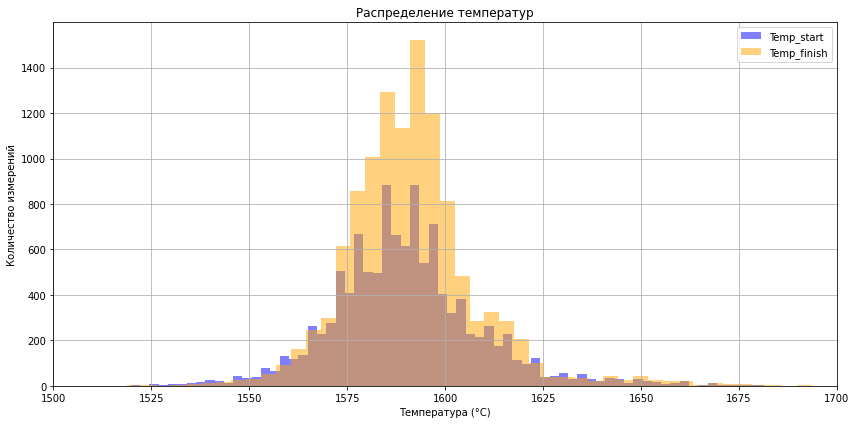

In [77]:
# Выведем распределения начальных и конечных температур на один график
plt.figure(figsize=(12, 6))
plt.hist(data_temp['Temp_start'].dropna(), bins=80, alpha=0.5, color='blue', label='Temp_start')
plt.hist(data_temp['Temp_finish'].dropna(), bins=50, alpha=0.5, color='orange', label='Temp_finish')
plt.title('Распределение температур')
plt.xlabel('Температура (°C)')
plt.ylabel('Количество измерений')
plt.xlim(1500, 1700)  # Устанавливаем границы по оси X
plt.grid(True)
plt.legend()
plt.tight_layout()

# Показываем график
plt.show()

1      33
2     136
3     394
4     688
5     579
6     388
7     151
8      66
9      21
10      7
11      3
12      2
13      2
15      2
16      1
Name: key, dtype: int64

<AxesSubplot: >

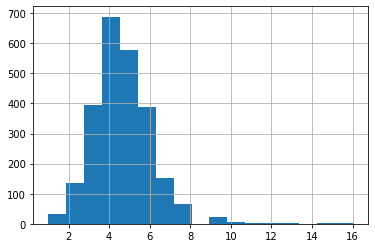

In [78]:
# Подсчитаем количество циклов замера температуры для каждой партии и распределение количества циклов на партию
measurement_count = data_temp['key'].value_counts()
display(measurement_count.value_counts().sort_index())
measurement_count.hist(bins=17)

Удалим партии с количеством циклов более семи, так как есть основания полагать что там были отклонения от стандартного процесса производства и количество замеров увеличилось при исправлении ситуации. Таких партий не много, в отличие от количества циклов которые они дают.  

In [79]:
# Создаём список партий с количеством циклов <= 7
valid_keys = measurement_count[measurement_count <= 7].index

# Фильтруем исходный датафрейм, оставляя только допустимые ключи
data_temp = data_temp[data_temp['key'].isin(valid_keys)]

data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10519 entries, 1 to 13925
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          10519 non-null  int64         
 1   Time_start   10519 non-null  datetime64[ns]
 2   Temp_start   10519 non-null  float64       
 3   Time_finish  10519 non-null  datetime64[ns]
 4   Temp_finish  10519 non-null  float64       
 5   Duration     10519 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 575.3 KB


#### Объединение данных

Начнем формировать основной датасет для обучения моделей.

In [80]:
# Создадим функцию для создания отдельных датафреймов для каждой проволоки (Wire)
def create_wire_dataframes(data_wire_time, data_wire, wire_columns):
    """
    Создает отдельные датафреймы для каждой проволоки (Wire)
    
    Параметры:
    - data_wire_time: исходный датафрейм с временными данными
    - data_wire: исходный датафрейм с данными проводов
    - wire_columns: список названий проводов (например, ['Wire 1', 'Wire 2', ...])
    
    Возвращает:
    Словарь с датафреймами для каждого провода
    """
    wire_dfs = {}
    
    for wire in wire_columns:
        # Создаем новый датафрейм для текущего провода
        df = pd.DataFrame({
            'key': data_wire_time['key'],
            f'{wire}_time': data_wire_time[wire],  # сохраняем суффикс _time для data_wire_time
            wire: data_wire[wire]  # сохраняем оригинальное название для data_wire
        })
        
        # Сохраняем датафрейм в словарь
        wire_dfs[wire] = df
    
    return wire_dfs

In [81]:
# Создаем отдельные датафреймы
wire_columns = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']
wire_dfs = create_wire_dataframes(data_wire_time, data_wire, wire_columns)

# Пример доступа к созданному датафрейму
wire_dfs['Wire 2'].head(5)

,key,Wire 2_time,Wire 2
0,1,NaT,0.00000
1,2,NaT,0.00000
2,3,NaT,0.00000
3,4,NaT,0.00000
4,5,2019-05-03 13:15:34,9.11456


In [82]:
# Удалим строки с пропусками
for wire in wire_dfs:
    wire_dfs[wire] = wire_dfs[wire].dropna()
# Проверим на одной из проволок
wire_dfs['Wire 2'].head(5)

,key,Wire 2_time,Wire 2
4,5,2019-05-03 13:15:34,9.114560
5,6,2019-05-03 13:48:52,9.114560
8,9,2019-05-03 15:39:37,9.143681
9,10,2019-05-03 16:22:36,12.376000
12,13,2019-05-03 18:40:57,52.416003


In [83]:
# Создадим функцию для присоединения данных по проволоке к data_temp по времени и партии

def merge_with_time_interval(data_temp, wire_dfs, wire_columns):
    """
    Присоединяет данные проводов к data_temp по времени и партии
    
    Параметры:
    - data_temp: основной датафрейм с интервалами времени
    - wire_dfs: словарь с датафреймами проводов
    - wire_columns: список названий проводов
    """    
    for wire in wire_columns:
        # Получаем текущий датафрейм провода
        wire_df = wire_dfs[wire]
        
        # Преобразуем время в datetime
        wire_df[f'{wire}_time'] = pd.to_datetime(wire_df[f'{wire}_time'])
        
        # Создаем временный датафрейм для присоединения
        temp = data_temp.copy()
        
        # Выполняем соединение по партии
        merged = pd.merge(
            temp,
            wire_df,
            left_on='key',
            right_on='key',
            how='left'
        )
        
        # Фильтруем по временному интервалу
        merged = merged[
            (merged[f'{wire}_time'] >= merged['Time_start']) &
            (merged[f'{wire}_time'] <= merged['Time_finish'])
        ]
        
        # Оставляем только нужные колонки
        merged = merged[['key', 'Time_start', 'Time_finish', wire]]
        
        # Удаляем дубликаты по партии и времени
        merged = merged.drop_duplicates(subset=['key', 'Time_start', 'Time_finish'])
        
        # Присоединяем к основному датафрейму
        data_temp = pd.merge(
            data_temp,
            merged,
            on=['key', 'Time_start', 'Time_finish'],
            how='left'
        )
    
    return data_temp


In [84]:
# Наконец, присоединеним отдельные данные по Wire к data_temp и начнем формировать датафрейм для моделей

main_df_cycle = merge_with_time_interval(
    data_temp,
    wire_dfs,
    wire_columns
)

main_df_cycle.head(5)

,key,Time_start,Temp_start,Time_finish,Temp_finish,Duration,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:07:18,1604.0,314.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-05-03 11:07:18,1604.0,2019-05-03 11:11:34,1618.0,256.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2019-05-03 11:11:34,1618.0,2019-05-03 11:18:04,1601.0,390.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2019-05-03 11:18:04,1601.0,2019-05-03 11:25:59,1606.0,475.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2019-05-03 11:25:59,1606.0,2019-05-03 11:30:38,1613.0,279.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Данные по проволоке (Wire) успешно добавлены. Проделаем аналогичные операции с данными по загрузке сыпучих компонентов (Bulk).

In [85]:
# Создаем отдельные датафреймы
bulk_columns = ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 
                'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']
bulk_dfs = create_wire_dataframes(data_bulk_time, data_bulk, bulk_columns)

# Пример доступа к созданному датафрейму
bulk_dfs['Bulk 1'].head(5)

,key,Bulk 1_time,Bulk 1
0,1,NaT,0.0
1,2,NaT,0.0
2,3,NaT,0.0
3,4,NaT,0.0
4,5,NaT,0.0


In [86]:
# Присоединеним отдельные данные по Bulk к main_df 

main_df_cycle = merge_with_time_interval(
    main_df_cycle,
    bulk_dfs,
    bulk_columns
)
main_df_cycle.head(5)

,key,Time_start,Temp_start,Time_finish,Temp_finish,Duration,Wire 1,Wire 2,Wire 3,Wire 4,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:07:18,1604.0,314.0,60.059998,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-05-03 11:07:18,1604.0,2019-05-03 11:11:34,1618.0,256.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.0
2,1,2019-05-03 11:11:34,1618.0,2019-05-03 11:18:04,1601.0,390.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150.0,NaN
3,1,2019-05-03 11:18:04,1601.0,2019-05-03 11:25:59,1606.0,475.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,NaN,NaN
4,1,2019-05-03 11:25:59,1606.0,2019-05-03 11:30:38,1613.0,279.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Данные успешно присоединены. Продолжим формировать основной датасет, на очереди присоединение данных по нагрузке. 
<br>
Для присоединения данных data_arc интервал подачи нагрузки 'BeginHeat' и 'EndHeat' усредним. Это позволит нам в случае если интервал подачи энергии пересекается сразу с двумя интервалами main_df отнести это воздействие к тому интервалу где оно было максимальным по продолжительности.   

In [87]:
data_arc.head(5)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,Power_ratio,HeatingDuration,Heating
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.692338,228.0,69.569640
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.623566,185.0,141.646730
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.741772,172.0,99.813836
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.732848,365.0,189.251040
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0.742321,148.0,128.335684


In [88]:
# Добавляем столбец среднего времени
data_arc['AvgTime'] = (data_arc['BeginHeat'] + (data_arc['EndHeat'] - data_arc['BeginHeat'])/2)
data_arc.head(5)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,Power_ratio,HeatingDuration,Heating,AvgTime
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.692338,228.0,69.569640,2019-05-03 11:04:08.000
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.623566,185.0,141.646730,2019-05-03 11:09:00.500
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.741772,172.0,99.813836,2019-05-03 11:13:10.000
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.732848,365.0,189.251040,2019-05-03 11:21:16.500
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0.742321,148.0,128.335684,2019-05-03 11:27:23.000


In [89]:
def merge_with_main_df(main_df, data_arc, arc_columns):
    """
    Присоединяет данные из data_arc к main_df по временным интервалам и партии
    
    Параметры:
    - main_df: основной датафрейм с интервалами времени
    - data_arc: датафрейм с данными нагрузки
    - arc_columns: список названий колонок для присоединения 
    """
    # Создаем временный датафрейм для присоединения
    temp = main_df.copy()
    
    # Выполняем соединение по ключу
    merged = pd.merge(
        temp,
        data_arc,
        on='key',
        how='left'
    )
    # Фильтруем по временному интервалу
    merged = merged[
        (merged['BeginHeat'] <= merged['Time_finish']) &
        (merged['EndHeat'] >= merged['Time_start'])
    ]
    # Оставляем только нужные колонки
    selected_columns = ['key', 'Time_start', 'Time_finish'] + arc_columns
    merged = merged[selected_columns]
    
    # Удаляем дубликаты по ключевым полям
    merged = merged.drop_duplicates(subset=['key', 'Time_start', 'Time_finish'])
    
    # Присоединяем к основному датафрейму
    result = pd.merge(
        main_df,
        merged,
        on=['key', 'Time_start', 'Time_finish'],
        how='left'
    )
    return result

In [90]:
# Присоединеним данные по мощности к main_df 
arc_columns=['Heating', 'Power_ratio', 'HeatingDuration']
main_df_cycle = merge_with_main_df(
    main_df_cycle,
    data_arc,
    arc_columns
)
main_df_cycle.head()

,key,Time_start,Temp_start,Time_finish,Temp_finish,Duration,Wire 1,Wire 2,Wire 3,Wire 4,...,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Heating,Power_ratio,HeatingDuration
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:07:18,1604.0,314.0,60.059998,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.569640,0.692338,228.0
1,1,2019-05-03 11:07:18,1604.0,2019-05-03 11:11:34,1618.0,256.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,154.0,141.646730,0.623566,185.0
2,1,2019-05-03 11:11:34,1618.0,2019-05-03 11:18:04,1601.0,390.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,150.0,NaN,99.813836,0.741772,172.0
3,1,2019-05-03 11:18:04,1601.0,2019-05-03 11:25:59,1606.0,475.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,206.0,NaN,NaN,NaN,189.251040,0.732848,365.0
4,1,2019-05-03 11:25:59,1606.0,2019-05-03 11:30:38,1613.0,279.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128.335684,0.742321,148.0


In [91]:
data_gas.head(5)

,key,total_gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [92]:
# Выполняем левое присоединение данных data_gas по партии
main_df_cycle = pd.merge(
    main_df_cycle,
    data_gas,
    on='key',
    how='left'
)
main_df_cycle.head(5)

,key,Time_start,Temp_start,Time_finish,Temp_finish,Duration,Wire 1,Wire 2,Wire 3,Wire 4,...,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Heating,Power_ratio,HeatingDuration,total_gas
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:07:18,1604.0,314.0,60.059998,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,69.569640,0.692338,228.0,29.749986
1,1,2019-05-03 11:07:18,1604.0,2019-05-03 11:11:34,1618.0,256.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,154.0,141.646730,0.623566,185.0,29.749986
2,1,2019-05-03 11:11:34,1618.0,2019-05-03 11:18:04,1601.0,390.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,150.0,NaN,99.813836,0.741772,172.0,29.749986
3,1,2019-05-03 11:18:04,1601.0,2019-05-03 11:25:59,1606.0,475.0,NaN,NaN,NaN,NaN,...,NaN,NaN,206.0,NaN,NaN,NaN,189.251040,0.732848,365.0,29.749986
4,1,2019-05-03 11:25:59,1606.0,2019-05-03 11:30:38,1613.0,279.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,128.335684,0.742321,148.0,29.749986


Наши циклы сформированы, однако есть проблема. Параметр total_gas - это суммарный газ на партию, а не на цикл. Добавим столбец 'gas' с расчетом его объема с учетом длительности цикла относительно длительности партии.

In [93]:
# Группируем по партиям и считаем общую длительность для каждой партии
total_duration = main_df_cycle.groupby('key')['Duration'].transform('sum')

# Рассчитываем долю длительности для каждого цикла
duration_ratio = main_df_cycle['Duration'] / total_duration

# Рассчитываем gas как произведение total_gas на долю цикла
main_df_cycle['gas'] = main_df_cycle['total_gas'] * duration_ratio

main_df_cycle.head()

,key,Time_start,Temp_start,Time_finish,Temp_finish,Duration,Wire 1,Wire 2,Wire 3,Wire 4,...,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Heating,Power_ratio,HeatingDuration,total_gas,gas
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:07:18,1604.0,314.0,60.059998,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,69.569640,0.692338,228.0,29.749986,5.450114
1,1,2019-05-03 11:07:18,1604.0,2019-05-03 11:11:34,1618.0,256.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,154.0,141.646730,0.623566,185.0,29.749986,4.443405
2,1,2019-05-03 11:11:34,1618.0,2019-05-03 11:18:04,1601.0,390.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,150.0,NaN,99.813836,0.741772,172.0,29.749986,6.769250
3,1,2019-05-03 11:18:04,1601.0,2019-05-03 11:25:59,1606.0,475.0,NaN,NaN,NaN,NaN,...,NaN,206.0,NaN,NaN,NaN,189.251040,0.732848,365.0,29.749986,8.244599
4,1,2019-05-03 11:25:59,1606.0,2019-05-03 11:30:38,1613.0,279.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,128.335684,0.742321,148.0,29.749986,4.842617


In [94]:
main_df_cycle.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10519 entries, 0 to 10518
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   key              10519 non-null  int64         
 1   Time_start       10519 non-null  datetime64[ns]
 2   Temp_start       10519 non-null  float64       
 3   Time_finish      10519 non-null  datetime64[ns]
 4   Temp_finish      10519 non-null  float64       
 5   Duration         10519 non-null  float64       
 6   Wire 1           2243 non-null   float64       
 7   Wire 2           795 non-null    float64       
 8   Wire 3           31 non-null     float64       
 9   Wire 4           7 non-null      float64       
 10  Wire 5           0 non-null      float64       
 11  Wire 6           38 non-null     float64       
 12  Wire 7           1 non-null      float64       
 13  Wire 8           12 non-null     float64       
 14  Wire 9           28 non-null     float

In [95]:
# Очистим main_df от столбцов со временем, key и total_gas
main_df_cycle = main_df_cycle.drop(columns=['key', 'Time_start', 'Time_finish', 'total_gas'])

In [96]:
# Удалим строки main_df_cycle с пропусками в столбцах Heating, Power_ratio и HeatingDuration
main_df_cycle = main_df_cycle.dropna(subset=['Heating', 'Power_ratio', 'HeatingDuration'])

In [97]:
# Заполним оставшиеся пропуски в Bulk и Wire нулевыми значениями
main_df_cycle = main_df_cycle.fillna(0)

main_df_cycle.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10518 entries, 0 to 10518
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Temp_start       10518 non-null  float64
 1   Temp_finish      10518 non-null  float64
 2   Duration         10518 non-null  float64
 3   Wire 1           10518 non-null  float64
 4   Wire 2           10518 non-null  float64
 5   Wire 3           10518 non-null  float64
 6   Wire 4           10518 non-null  float64
 7   Wire 5           10518 non-null  float64
 8   Wire 6           10518 non-null  float64
 9   Wire 7           10518 non-null  float64
 10  Wire 8           10518 non-null  float64
 11  Wire 9           10518 non-null  float64
 12  Bulk 1           10518 non-null  float64
 13  Bulk 2           10518 non-null  float64
 14  Bulk 3           10518 non-null  float64
 15  Bulk 4           10518 non-null  float64
 16  Bulk 5           10518 non-null  float64
 17  Bulk 6      

Приступим с оптимизации нашего датасета. Начнем с удаления столбцов с найменьшим количеством информации.

In [98]:
# Посмотрим количество полезной информации в столбцах
zero_counts_per_column = (main_df_cycle == 0).sum()
info_percentage = (1-(zero_counts_per_column / len(main_df_cycle))) * 100

info_percentage.sort_values()

Wire 5               0.000000
Bulk 8               0.009508
Wire 7               0.009508
Wire 4               0.066553
Bulk 7               0.076060
Bulk 2               0.076060
Bulk 13              0.104583
Bulk 9               0.114090
Wire 8               0.114090
Wire 9               0.266210
Wire 3               0.294733
Wire 6               0.361285
Bulk 5               0.399315
Bulk 11              1.140901
Bulk 10              1.274006
Bulk 1               1.739875
Bulk 6               3.841034
Bulk 4               7.463396
Wire 2               7.558471
Bulk 3               8.661342
Bulk 15             15.421183
Bulk 12             16.989922
Bulk 14             19.357292
Wire 1              21.325347
Heating            100.000000
Power_ratio        100.000000
Temp_start         100.000000
Duration           100.000000
Temp_finish        100.000000
HeatingDuration    100.000000
gas                100.000000
dtype: float64

Wire 5 - пустой столбец, также есть несколько столбцов с минимальным объемом информации. Объединим данные по ним в отдельные столбцы Wire_other и Bulk_other.

In [99]:
# Объединим данные по столбцам в которых info_percentage менее 0.25 в отдельные столбцы Wire_other и Bulk_other

sorted_info = info_percentage.sort_values()
low_info_columns = sorted_info[sorted_info < 0.25].index
main_df_cycle['Wire_other'] = 0
main_df_cycle['Bulk_other'] = 0
wire_columns = [col for col in low_info_columns if 'Wire' in col]
bulk_columns = [col for col in low_info_columns if 'Bulk' in col]

if wire_columns:
    main_df_cycle['Wire_other'] = main_df_cycle[wire_columns].sum(axis=1)
    main_df_cycle.drop(columns=wire_columns, inplace=True)

if bulk_columns:
    main_df_cycle['Bulk_other'] = main_df_cycle[bulk_columns].sum(axis=1)
    main_df_cycle.drop(columns=bulk_columns, inplace=True)

# Проверим результат
main_df_cycle.columns

Index(['Temp_start', 'Temp_finish', 'Duration', 'Wire 1', 'Wire 2', 'Wire 3',
       'Wire 6', 'Wire 9', 'Bulk 1', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 14', 'Bulk 15', 'Heating',
       'Power_ratio', 'HeatingDuration', 'gas', 'Wire_other', 'Bulk_other'],
      dtype='object')

#### Корреляционный анализ

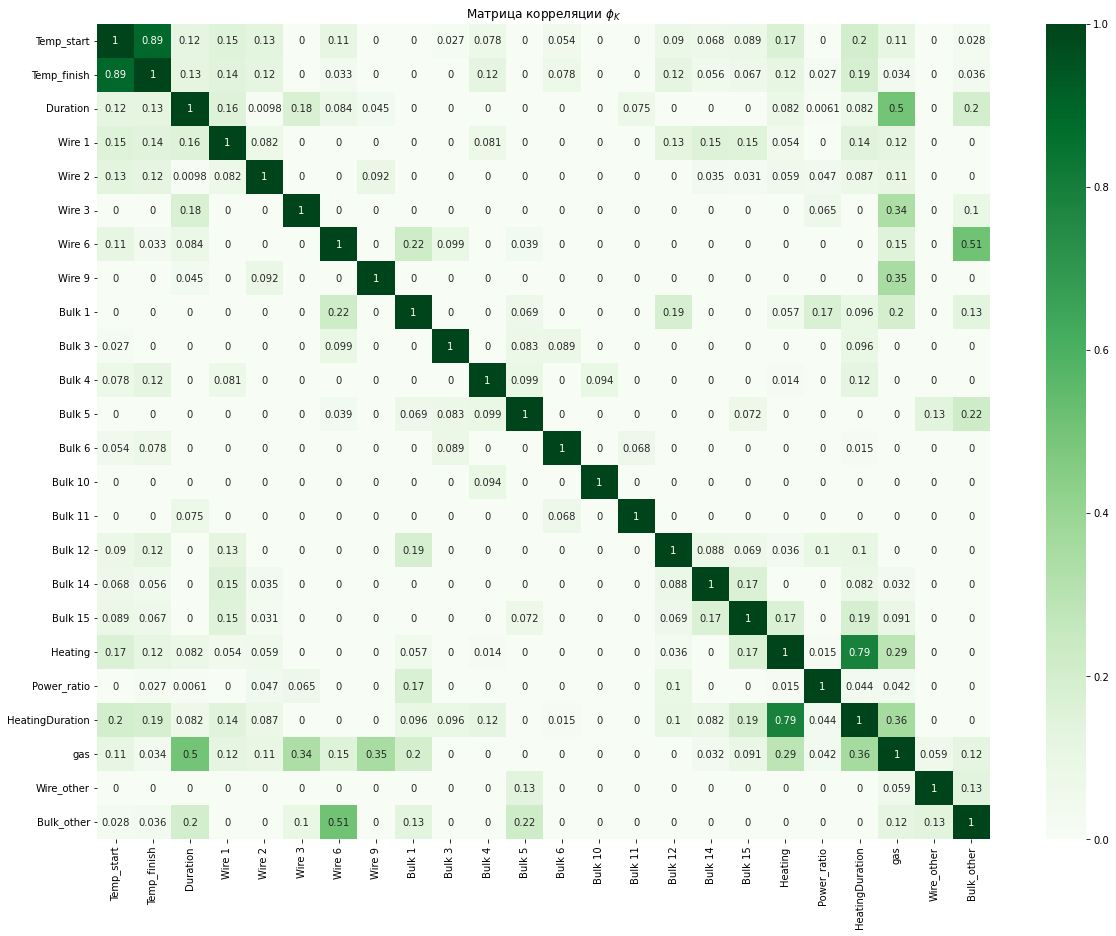

In [100]:
# Обозначим количественные признаки для матрицы
interval_cols = main_df_cycle.columns.tolist()

# Выведем матрицу корреляции
target_matrix = main_df_cycle.phik_matrix(interval_cols = interval_cols)
plt.figure(figsize=(20, 15))
sns.heatmap(target_matrix, annot=True, cmap='Greens')
plt.title('Матрица корреляции $\phi_K$')
plt.show()

#### Обучение модели и проверка на тестовых данных

In [101]:
# Подготовим выборки для обучения моделей

# Разделим датасет на входные признаки и целевой
X = main_df_cycle.drop('Temp_finish', axis=1)
y = main_df_cycle['Temp_finish']

# Разделим данные на тренировочные и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE)

# Стандартизируем числовые признаки
scaler = StandardScaler()

# Применим масштабирование только к тренировочной выборке
X_train = scaler.fit_transform(X_train)

# Применим то же масштабирование к тестовой выборке
X_test = scaler.transform(X_test)

In [102]:
# Обучим оптимальную, по данным предыдущего исследования, модель 

catboost_results = evaluate_model(CatBoostRegressor(verbose=0), catboost_params)

print(f"Лучшие параметры: {catboost_results['best_params']}")
print(f"MAE: {catboost_results['mae']:.4f}\n") 

Лучшие параметры: {'depth': 8, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.03}
MAE: 6.9669



In [103]:
# Проверим результат на тестовой выборке
best_estimator_cycle = catboost_results['best_estimator']
y_test_pred = best_estimator_cycle.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"\nMAE на тестовых данных: {test_mae:.4f}")


MAE на тестовых данных: 7.1316


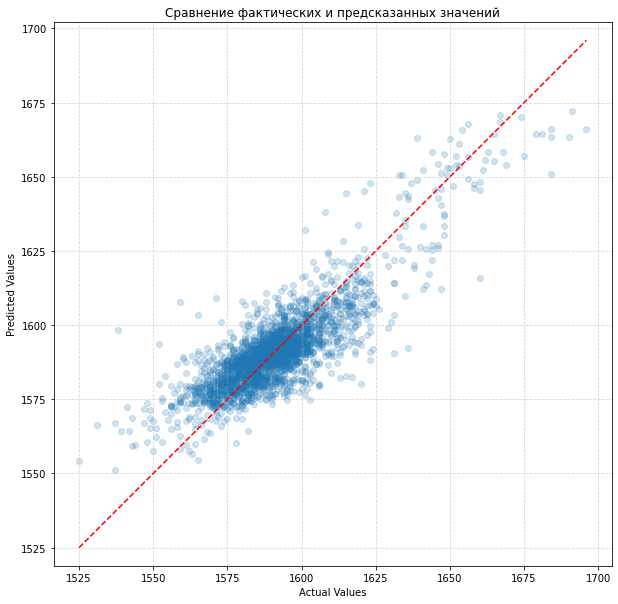

In [104]:
# Построим график сравнения фактических и предсказанных значений
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_test_pred, alpha=0.2)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.axis('equal')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Сравнение фактических и предсказанных значений')
plt.show()


Анализ важности признаков для модели CatBoost:


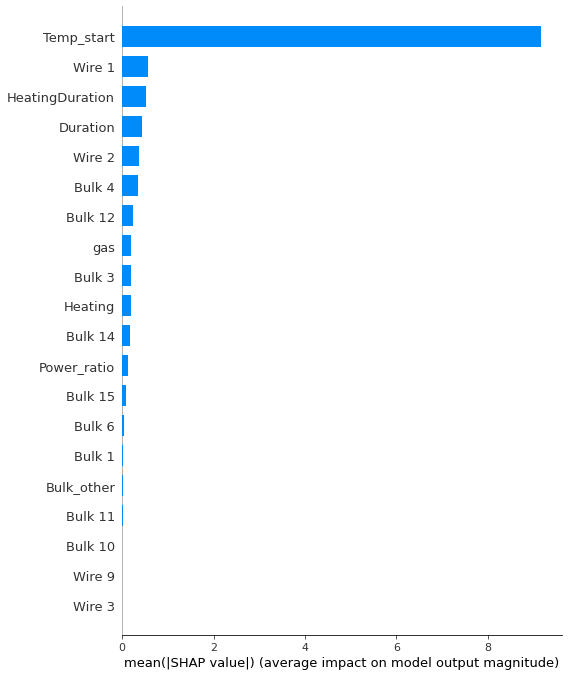

In [105]:
# Создаем explainer для CatBoost
explainer = shap.TreeExplainer(best_estimator_cycle)
shap_values = explainer.shap_values(X_test)
X_test_df = pd.DataFrame(X_test, columns=X.columns)
expected_value = explainer.expected_value

# Анализ результатов
print("\nАнализ важности признаков для модели CatBoost:")
shap.summary_plot(shap_values, X_test_df, plot_type='bar')

#### Вывод по дополнительной модели

Судя по графику сопоставления предсказаний модели и фактических значений модель демонстрирует хорошие результаты, с метрикой на кросс-валидации МАЕ=6.97 и тестовых данных МАЕ=7.13. Влияния признаков схожее с лучшей моделью из основной части проекта. 
Данная модель рекомендуется к применению для прогноза промежуточных значений температуры при имитации технологического процесса.